## Data Exploration: Heston Simulation Validation

This notebook validates the Heston simulation with Inverse Gaussian scheme.

In [39]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.utils.config import load_config
from src.data.heston import HestonSimulator, get_or_generate_dataset

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Load Configuration

In [40]:
config = load_config('../configs/config_sanity.yaml') 
heston_params = config['data']['heston']

print("Heston parameters:")
for key, value in heston_params.items():
    print(f"  {key}: {value}")

print(f"\nSimulation parameters:")
print(f"  T: {config['data']['T']}")
print(f"  n_steps: {config['data']['n_steps']}")

Heston parameters:
  S_0: 100.0
  K: 100.0
  r: 0.02
  mu: 0.05
  v_0: 0.04
  kappa: 1.5768
  theta: 0.04
  xi: 1e-10
  rho: -0.5711

Simulation parameters:
  T: 0.0833
  n_steps: 30


### 2. Simulate Paths

In [41]:
simulator = HestonSimulator(heston_params)

n_paths = 100000
T = config['data']['T']
n_steps = config['data']['n_steps']
dt = T / n_steps

print(f"Simulating {n_paths} paths with {n_steps} steps (T={T} years, dt={dt:.6f})...")
S, v = simulator.simulate(n_paths, T, n_steps, seed=42)
print(f"Simulation complete")
print(f"S shape: {S.shape}, v shape: {v.shape}")

Simulating 100000 paths with 30 steps (T=0.0833 years, dt=0.002777)...
Simulation complete
S shape: (100000, 31), v shape: (100000, 31)


### 3. Visualize Sample Paths

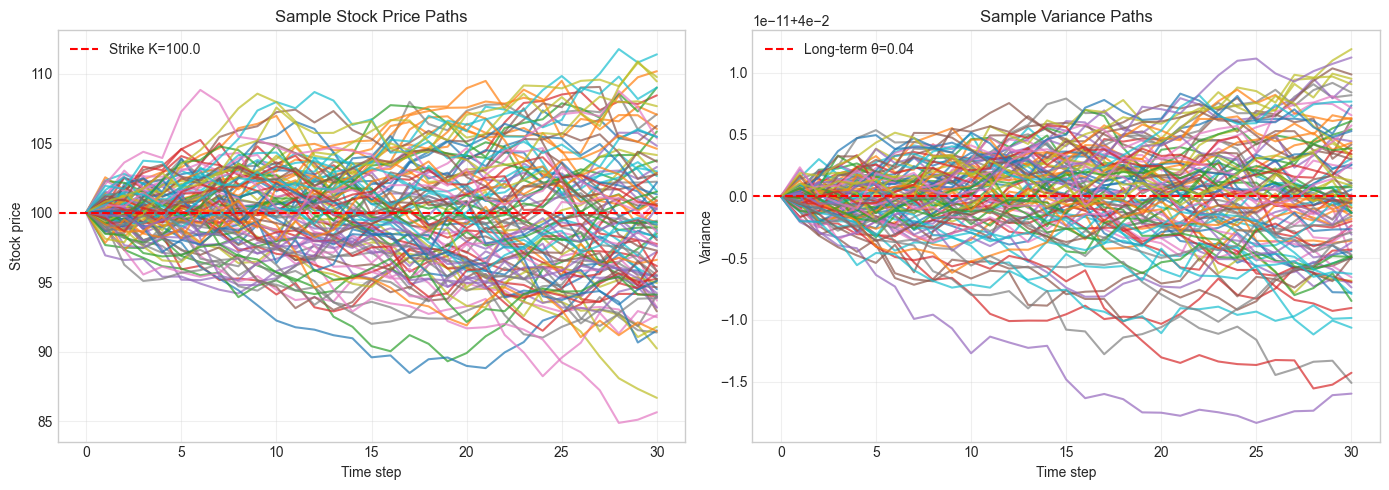

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stock price paths
axes[0].plot(S[:100].T, alpha=0.7)
axes[0].axhline(heston_params['K'], color='red', linestyle='--', label=f'Strike K={heston_params["K"]}')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Stock price')
axes[0].set_title('Sample Stock Price Paths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Variance paths
axes[1].plot(v[:100].T, alpha=0.7)
axes[1].axhline(heston_params['theta'], color='red', linestyle='--', label=f'Long-term θ={heston_params["theta"]}')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Variance')
axes[1].set_title('Sample Variance Paths')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/heston_sample_paths.pdf')
plt.show()

### 4. Validate Variance Moments

In [43]:
# Theoretical moments at time T
kappa = heston_params['kappa']
theta = heston_params['theta']
xi = heston_params['xi']
v_0 = heston_params['v_0']

# E[v_T] = v_0 * exp(-kappa*T) + theta * (1 - exp(-kappa*T))
E_v_T_theo = v_0 * np.exp(-kappa * T) + theta * (1 - np.exp(-kappa * T))

# Empirical
E_v_T_emp = np.mean(v[:, -1])

print("Variance Moment Validation:")
print(f"  E[v_T] theoretical: {E_v_T_theo:.6f}")
print(f"  E[v_T] empirical:   {E_v_T_emp:.6f}")
print(f"  Relative error:     {abs(E_v_T_emp - E_v_T_theo) / E_v_T_theo * 100:.2f}%")

# Check positivity
min_v = np.min(v)
print(f"\nPositivity check:")
print(f"  Min variance: {min_v:.6f}")
print(f"  Positivity preserved: {min_v > 0}")

Variance Moment Validation:
  E[v_T] theoretical: 0.040000
  E[v_T] empirical:   0.040000
  Relative error:     0.00%

Positivity check:
  Min variance: 0.040000
  Positivity preserved: True


### 5. Terminal Distribution Analysis

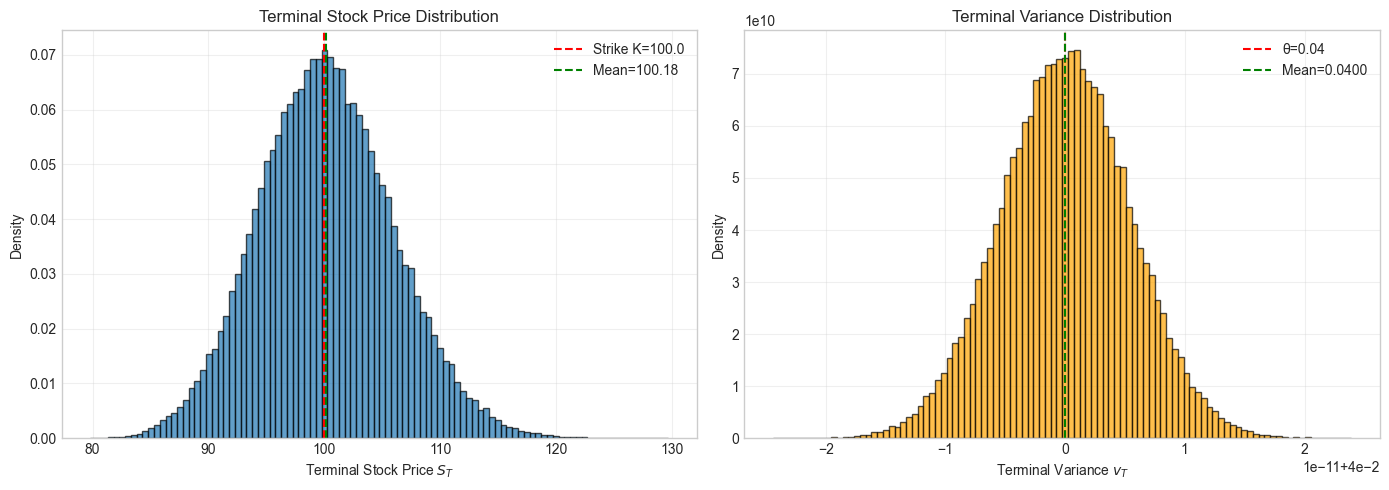

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Terminal stock price distribution
axes[0].hist(S[:, -1], bins=100, density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(heston_params['K'], color='red', linestyle='--', label=f'Strike K={heston_params["K"]}')
axes[0].axvline(np.mean(S[:, -1]), color='green', linestyle='--', label=f'Mean={np.mean(S[:, -1]):.2f}')
axes[0].set_xlabel('Terminal Stock Price $S_T$')
axes[0].set_ylabel('Density')
axes[0].set_title('Terminal Stock Price Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Terminal variance distribution
axes[1].hist(v[:, -1], bins=100, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1].axvline(theta, color='red', linestyle='--', label=f'θ={theta}')
axes[1].axvline(np.mean(v[:, -1]), color='green', linestyle='--', label=f'Mean={np.mean(v[:, -1]):.4f}')
axes[1].set_xlabel('Terminal Variance $v_T$')
axes[1].set_ylabel('Density')
axes[1].set_title('Terminal Variance Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/heston_terminal_distributions.pdf')
plt.show()

### 6. Option Payoff Analysis

In [47]:
K = heston_params['K']

# Call option payoff
call_payoff = np.maximum(S[:, -1] - K, 0)

print("Call Option Payoff Statistics:")
print(f"  Mean payoff:   {np.mean(call_payoff):.4f}")
print(f"  Std payoff:    {np.std(call_payoff):.4f}")
print(f"  Max payoff:    {np.max(call_payoff):.4f}")
print(f"  ITM ratio:     {np.mean(S[:, -1] > K) * 100:.2f}%")

# Discounted expected payoff (approximate call price)
r = heston_params['r']
approx_price = np.exp(-r * T) * np.mean(call_payoff)
print(f"\nApproximate Call Price (MC): {approx_price:.4f}")

Call Option Payoff Statistics:
  Mean payoff:   2.3983
  Std payoff:    3.5573
  Max payoff:    29.6910
  ITM ratio:     50.16%

Approximate Call Price (MC): 2.3943


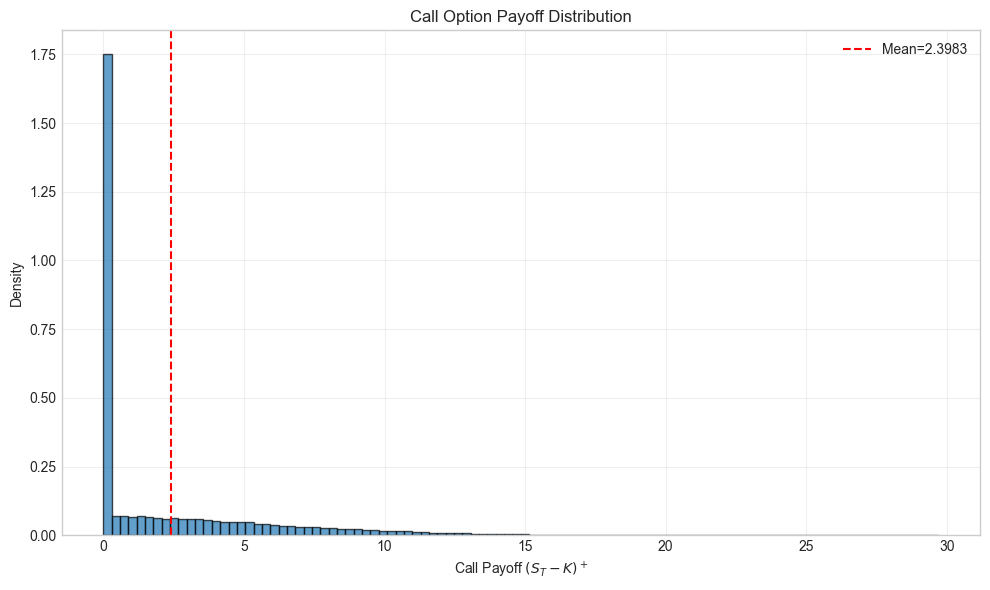

In [48]:
# Payoff distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(call_payoff, bins=100, density=True, alpha=0.7, edgecolor='black')
ax.axvline(np.mean(call_payoff), color='red', linestyle='--', 
           label=f'Mean={np.mean(call_payoff):.4f}')
ax.set_xlabel('Call Payoff $(S_T - K)^+$')
ax.set_ylabel('Density')
ax.set_title('Call Option Payoff Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/call_payoff_distribution.pdf')
plt.show()

### 7. Generate Full Dataset

In [49]:
# Generate train/val/test datasets using caching system
cache_dir = config.get('caching', {}).get('directory', 'cache')

print("Generating/loading datasets...")
S_train, v_train, Z_train = get_or_generate_dataset(config, 'train', cache_dir)
S_val, v_val, Z_val = get_or_generate_dataset(config, 'val', cache_dir)
S_test, v_test, Z_test = get_or_generate_dataset(config, 'test', cache_dir)

print(f"\nDataset sizes:")
print(f"  Train: {S_train.shape[0]} paths")
print(f"  Val:   {S_val.shape[0]} paths")
print(f"  Test:  {S_test.shape[0]} paths")

Generating/loading datasets...
[Heston] Loading cached train dataset from cache_sanity/train_7ce7df6c.npz
[Heston] Loading cached val dataset from cache_sanity/val_83800c76.npz
[Heston] Loading cached test dataset from cache_sanity/test_fa4b8921.npz

Dataset sizes:
  Train: 100000 paths
  Val:   15000 paths
  Test:  15000 paths


### Summary

- Heston simulation with Inverse Gaussian scheme is validated
- Variance moments match theoretical values
- Positivity of variance is preserved
- Data generation pipeline is ready for training